In [ ]:
from lucifex.mesh import rectangle_mesh
from lucifex.fem import StaticFunction
from lucifex.solver import bvp_solver, BoundaryConditions, OptionsPETSc
from lucifex.viz import plot_mesh, plot_colormap, plot_streamlines
from lucifex.utils import is_tensor, interpolate_components_to_fem_function
from dolfinx.fem import Function
from ufl import dx, inner, inv, div, TestFunctions, TrialFunctions, FacetNormal


def darcy(
    u_p: StaticFunction,
    k,
    mu,
    p_bcs: BoundaryConditions | None = None,
):
    """
    `∇⋅u = 0` \\
    `u = -K⋅∇p / μ`
    
    `F(u,p;v,q) = ∫ q(∇·u) dx \\
    `+ ∫ v·(μ K⁻¹⋅u) dx - ∫ p(∇·v) dx + ∫ p(v·n) ds`

    NOTE use `pc_factor_mat_solver_type='mumps'`
    """

    v, q = TestFunctions(u_p.function_space)
    u, p = TrialFunctions(u_p.function_space)
    n = FacetNormal(u_p.function_space.mesh)
    
    F_div = q * div(u) * dx
    if is_tensor(k):
        F_velocity = inner(v, mu * inv(k) * u) * dx
    else:
        F_velocity = inner(v, mu * u / k) * dx
    F_pressure = -p * div(v) * dx

    forms = [F_div, F_velocity, F_pressure]

    if p_bcs is not None:
        F_bcs = [inner(v, n) * pi * dsi for pi, dsi in p_bcs.boundary_data(u_p.function_space)]
        forms.extend(F_bcs)

    return forms


# domain
Lx = 2.0
Ly = 1.0
mesh = rectangle_mesh(Lx, Ly, 100, 50, cell='right')

# permeability
k_lens = 0.1
c = (0.5 * Lx, 0.5 * Ly)
r = (0.2 * Lx, 0.2 * Ly)
k_x = lambda x: 1 + (k_lens - 1) * ((x[0] - c[0])**2 / r[0]**2 + (x[1] - c[1])**2 / r[1]**2 < 1)
k = StaticFunction((mesh, 'DP', 0), k_x)

# viscosity
mu = 1

# mixed function space
u_deg = 1
u_elem = ('BDM', u_deg)
p_elem = ('DP', u_deg - 1)
u_p_elem = [u_elem, p_elem]
u_p = StaticFunction((mesh, u_p_elem), name="u_p")

# velocity boundary conditions
u_bcs = BoundaryConditions(
    ('essential', lambda x: x[1], (0.0, 0.0), 0),
    ('essential', lambda x: x[1] - Ly, (0.0, 0.0), 0),
)
# pressure boundary conditions
p_bcs = BoundaryConditions(
    ('natural', lambda x: x[0], 1.0, 1),
    ('natural', lambda x: x[0] - Lx, 0.0, 1),
)

petsc = OptionsPETSc.default
petsc['pc_factor_mat_solver_type'] = 'mumps'
u_p_solver = bvp_solver(darcy, u_bcs, petsc)(u_p, k, mu, p_bcs)
u_p_solver.solve()

u, p = u_p.split(('u', 'p'), collapse=True)
ux, uy = interpolate_components_to_fem_function(u, ('P', 1), names=('ux', 'uy'))

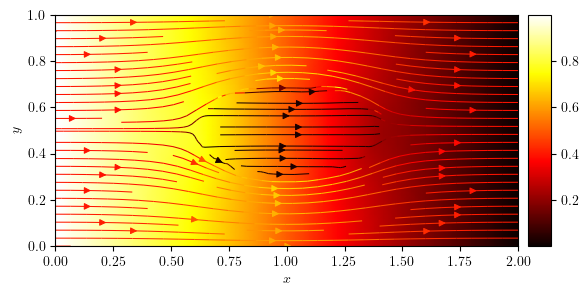

: 

In [ ]:
fig, ax = plot_colormap(p)
plot_streamlines(fig, ax, u, color='hot')

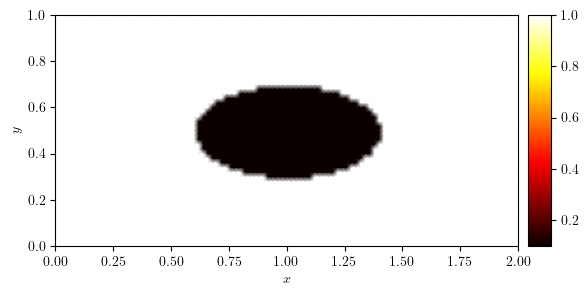

In [3]:
fig, ax = plot_mesh(mesh)
plot_colormap(fig, ax, k)